In [1]:
# Stylianos Topalidis
# AEM: 9613
# email: styltopa@ece.auth.gr 

In [117]:
from sklearn import datasets, tree
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier


# if the import below does not work please try opening a terminal and writing 
# pip install -U scikit-learn --user
# this worked for me at least in vscode.
# There is some discourse in the forum that it does not work in collab
# see https://stackoverflow.com/questions/72246343/importerror-cannot-import-name-decisionboundarydisplay-from-sklearn-inspecti
from sklearn.inspection import DecisionBoundaryDisplay
import random 
import math
from IPython.display import HTML, display
import tabulate


# Note: Please run the cells sequentially as some of them require the execution of 
# previous ones to run as expected

# Part A

# Load data
iris = datasets.load_iris()

# Percentage of the data for the training 
trainPercent = 0.5


# Exclude duplicates of target values using set (multiple 0, 1 and 2)
# Turn the set into a list and then into a numpy array
# for convenience 
targetArr = np.array(list(set(iris.target)))



# - indsPerKind: Indexes per flower kind in iris.data (iterates over the
#  different targets: setosa, versicolor, virginica) 
# - trainingInds, testingInds: Indexes for the training and
#  testing data in the original dataset. 
indsPerKind = []
trainingInds = []
testingInds = []

# For each flower kind
for targetCount in range(len(targetArr)):

    # Only the first element of the returned array is the actual indexes  
    indsPerKind = list(np.where(iris.target == targetCount)[0]) 
    
    # number of training data derived from the training percentage selected
    # per group kind (0, 1, 2)
    numOfTrainingDataPerKind = round(trainPercent*len(indsPerKind))
    numOfTestingDataPerKind = len(indsPerKind) - numOfTrainingDataPerKind

    # Concatenate the indices of the new target (kind) training data 
    # with the indices of the old target training data
    trainingInds = trainingInds + indsPerKind[0:numOfTrainingDataPerKind]
    testingInds = testingInds + indsPerKind[numOfTrainingDataPerKind:]
    

# list -> np.array
trainingInds = np.array(trainingInds)
testingInds = np.array(testingInds)

# To avoid training the tree with batches of data of the same target,
# as given (all setosa first, then all versicolor and finally all virginica),
# we permute the training data.
rnd  = random.random()
random.seed(rnd)
trainingIndsPerm =  np.random.permutation(trainingInds)


# Training data and target values
trainingArr = iris.data[trainingIndsPerm, 0:2]
targetArrTraining = iris.target[trainingIndsPerm]

# Testing data and target values
testingArr = iris.data[testingInds, 0:2]
targetArrTesting = iris.target[testingInds]

# List with the accuracies of all decision tree classifiers per depth of tree
accList = list()

numOfTrainingData = len(targetArr)*numOfTrainingDataPerKind


# A.1

print('Decision Tree Classifier')

# Different depths of the decision tree classifier
treeDepths = np.array([1, 2, 3, 4, 5, 6, 7])

# Train classifier per depth
for depthCount, depth in enumerate(treeDepths):
    # Classifier training
    clf = tree.DecisionTreeClassifier(max_depth=depth)
    clf = clf.fit(trainingArr, targetArrTraining)
    
    # Classifier predictions of the targets
    targetArrPred = clf.predict(testingArr)


    # number of correctly predicted target values
    correctlyPredicted = 0

    targetAndPred = np.stack((targetArrTesting, targetArrPred), axis=1) 

    for predCount in range(numOfTrainingData):
        if targetArrTesting[predCount] == targetArrPred[predCount]: 
            correctlyPredicted = correctlyPredicted + 1

    accuracy = correctlyPredicted/numOfTrainingData
    accList.append([str(depth), str(round(100*accuracy, 1))])

    # Find the classifier with the best accuracy
    if depth == treeDepths[0]:
        maxAccClf = clf
        maxAcc = accuracy
    if maxAcc < accuracy:
        maxAccClf = clf
        maxAcc = accuracy

print('----------------------------------'
    '\nMax accuracy classifier is the one with depth = ', maxAccClf.tree_.max_depth, \
    'and accuracy: ', round(100*maxAcc, 2), '%')


# Plot the accuracies of the classifiers per tree depth
table = tabulate.tabulate(accList, tablefmt='html', headers=["Decision Tree depth", "Accuracy (%)"])
display(HTML(table))

# Remarks:
# For different executions of the program, the depth of the classifier with the best accuracy 
# is most often 4 and sometimes 5.
# The space partition of the classifier is different when different sequences
# of the training data are fed into the model. 
# For most cases however, the decision tree classifier depth that gives the best accuracy 
# is the one with depth 4 with accuracy 80%.

Decision Tree Classifier
----------------------------------
Max accuracy classifier is the one with depth =  5 and accuracy:  80.0 %


Decision Tree depth,Accuracy (%)
1,64
2,68
3,69.3
4,78.7
5,80
6,80
7,68


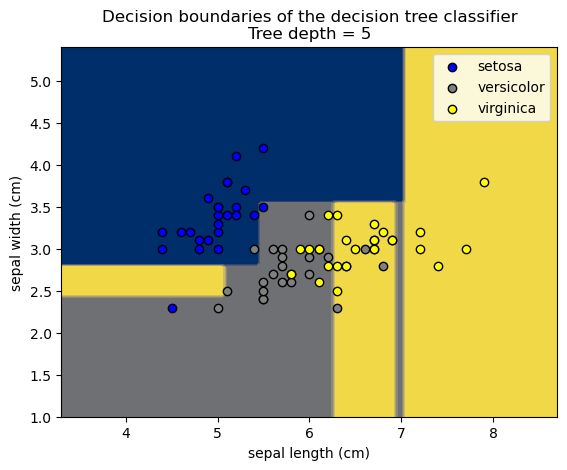

In [119]:
# A.2
# Plot the decision boundaries
decisionBoundDisp = DecisionBoundaryDisplay.from_estimator(
    maxAccClf, trainingArr,  cmap=plt.cm.cividis, response_method="predict",
    xlabel=iris.feature_names[0], ylabel=iris.feature_names[1],
    plot_method= 'contourf'
)

c  = ['blue', 'grey', 'yellow']

# Multiple scatter diagrams, one per kind of flower
for i, t in enumerate(targetArr):
    targetInds = np.where(targetArrTesting == t)
    plt.scatter(
        testingArr[targetInds, 0], testingArr[targetInds, 1], color=c[i], edgecolor="black", label = iris.target_names[i]
    )

decisionBoundDisp.ax_.set_title('Decision boundaries of the decision tree classifier\nTree depth = ' \
    + str(maxAccClf.tree_.max_depth))

plt.legend()


In [124]:
# Part B
# B.1

# Number of bootstrap samples and number of trees in the random forest classifier
B = 100
# Percentage of the original training data in the bootstrap samples
gamma = 0.5

# Number of elements per bootstrap sample
bootSamNumOfElem = round(gamma*numOfTrainingData)

# List with the accuracies of all classifiers per depth
accList = list()

# random seed to get the same bootstrap samples for every execution of the 
# program
rnd = random.random()

print('Random Forest Classifier\n------------------------------------')
# Forest tree max depths
treeDepths = np.array([1, 2, 3, 4, 5])
# Train the random forest classifier for different max depths of the decision trees
# to get the depth of the classifier with the maximum accuracy
for depthCount, depth in enumerate(treeDepths):
    
    random.seed(rnd)
    # Classifier training
    clf = RandomForestClassifier(n_estimators=B, max_depth=depth, bootstrap=True, max_samples=bootSamNumOfElem)
    clf = clf.fit(trainingArr, targetArrTraining)

    # Classifier predictions of the targets
    targetArrPred = clf.predict(testingArr)

# Calculation of accuracy 
    # Number of correctly predicted samples
    correctlyPredicted = 0
    # Contains two columns: one with the real and one with the predicted target values
    targetAndPred = np.stack((targetArrTesting, targetArrPred), axis=1) 
    for predCount in range(numOfTrainingData):
        if targetArrTesting[predCount] == targetArrPred[predCount]: 
            correctlyPredicted = correctlyPredicted + 1
       
    accuracy = correctlyPredicted/numOfTrainingData
    accList.append([str(depth), str(round(100*accuracy, 1))])
    # Find the max depth with the highest accuracy
    if depth == treeDepths[0]:
        maxAccClf = clf
        maxAcc = accuracy
        maxAccDepth = depth
    if maxAcc < accuracy:
        maxAccClf = clf
        maxAcc = accuracy
        maxAccDepth = depth

print('Max accuracy classifier is the one with decision tree depth = ', str(maxAccDepth), \
    'and accuracy: ', round(100*maxAcc, 2), '%')

# Display the acccuracy per depth in tabular form 
table = tabulate.tabulate(accList, tablefmt='html', headers=["Decision Tree depth", "Accuracy (%)"])
display(HTML(table))

# Remarks
# - For different executions of the program, the bootstrap samples differ, and 
# so do the resulting trees of random forest committee.
# Consequently, the best max depth for the trees (the one giving the maximum 
# accuracy of the model) is not the same for each execution. 
# - In the analysis in the last cell (you can uncomment the section but the code takes up 
# to a minute to run), the histogram shows that for different seeds
# the best accuracy is given in most cases (~50%) for max depths of the trees in the
# forest equal to 2 with an accuracy of 78.67%.

Random Forest Classifier
------------------------------------
Max accuracy classifier is the one with decision tree depth =  2 and accuracy:  81.33 %


Decision Tree depth,Accuracy (%)
1,77.3
2,81.3
3,74.7
4,73.3
5,70.7


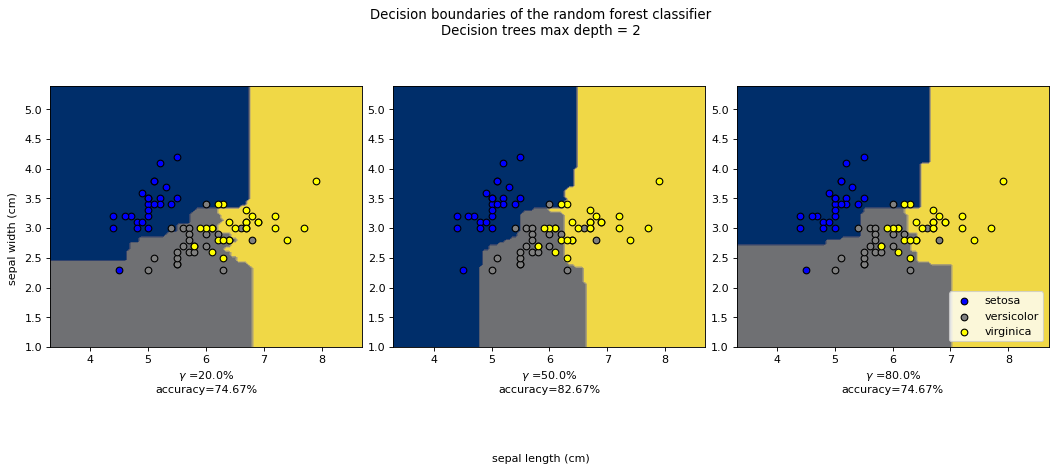

In [126]:
# B.2 

# Plot the decision boundaries of the classifiers for different percentage of
# the training data
fig = plt.figure(figsize=(15, 6), dpi=80)

# Set common labels for the plots in the figure
fig.text(0.5, 0.04, iris.feature_names[0], ha='center', va='center')
fig.text(0.06, 0.5, iris.feature_names[1], ha='center', va='center', rotation='vertical')

# The different percentages of the original training data to plot the 
# decision bounds for
gammaArr = [0.2, 0.5, 0.8]

for gammaCount, gammaVal in enumerate(gammaArr):
    
    # Different percentage (gamma) of the original training data is used each time
    bootSamNumOfElem = round(gammaVal*numOfTrainingData)

    # To get the same classifier for gamma = 0.5 as before
    random.seed(rnd)
    # Training for the different gamma values and for the maxAccDepth found before
    clf = RandomForestClassifier(n_estimators=B, max_depth=maxAccDepth, bootstrap=True, max_samples=bootSamNumOfElem)
    clf = clf.fit(trainingArr, targetArrTraining)

    # Classifier predictions of the targets
    targetArrPred = clf.predict(testingArr)

# Calculation of accuracy 

    # Number of correctly predicted samples
    correctlyPredicted = 0
    # contains both the real and the predicted target values
    targetAndPred = np.stack((targetArrTesting, targetArrPred), axis=1) 
    # for every sample prediction
    for predCount in range(numOfTrainingData):
        if targetArrTesting[predCount] == targetArrPred[predCount]: 
            correctlyPredicted = correctlyPredicted + 1
       
    accuracy = correctlyPredicted/numOfTrainingData

    # Plot a subplot for each gamma value
    ax = plt.subplot(1, len(gammaArr), gammaCount+1)        
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=7.5)
    decisionBoundDisp = DecisionBoundaryDisplay.from_estimator(
        clf, trainingArr,  cmap=plt.cm.cividis, response_method="predict",
        ax = ax,
        xlabel=r'$\gamma$ ='+ str(100*gammaVal)+ '%\naccuracy='+ str(round(100*accuracy, 2))+ '%',
        plot_method= 'contourf'
    )

    c  = ['blue', 'grey', 'yellow']

    for counter, target in enumerate(targetArr):
        targetInds = np.where(targetArrTesting == target)
        plt.scatter(
            testingArr[targetInds, 0], testingArr[targetInds, 1], color=c[counter], edgecolor="black", label = iris.target_names[counter]
        )


plt.suptitle('Decision boundaries of the random forest classifier\nDecision trees max depth = ' \
        + str(maxAccDepth))
plt.legend(loc='lower right')

# Reamarks
# In comparison to the simple decision tree classifier, 
# the random forest one seems to catch the data patterns in more detail 

# B.3
# The percentage of the training data (gamma) used for the bootstrap samples of 
# the individual decision trees in
# the forest, seems to change the accuracy of the final model.
# As gamma increases, accuracy tends to decrease (in most executions of the program
# because as it is mentioned before, different executions of the program provide different 
# classifiers and accuracy percentages).
# This is to be expected, as random forests exploit the idea that
# small subsamples of the original data contain classification information about the 
# that which is not visible when treating the data as a whole.
# Therefore, when gamma is small the classification is more accurate. 

<BarContainer object of 2 artists>

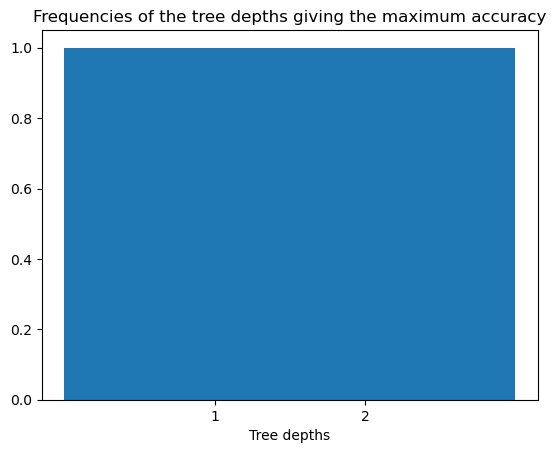

In [136]:
# Cell the tree depths giving the max accuracy 

# Number of bootstrap samples and number of trees in the random forest classifier
B = 100
# Percentage of the original training data in the bootstrap samples
gamma = 0.5

numOfTrainingData = len(targetArr)*numOfTrainingDataPerKind

# Number of elements per bootstrap sample
bootSamNumOfElem = round(gamma*numOfTrainingData)
maxAccDepthList = []

for j in range(1, 4):
    rnd = random.random()
    if j !=1:
        maxAccDepthList.append(maxAccDepth)
    # print('Classification accuracy\n------------------------------------')
    # Forest tree depths
    # treeDepths = np.array([1, 2, 3, 4, 5])
    treeDepths = np.array([1, 2])
    for depthCount in treeDepths:
        random.seed(rnd)
        # Classifier training
        clf = RandomForestClassifier(n_estimators=B, max_depth=depthCount, bootstrap=True, max_samples=bootSamNumOfElem)
        clf = clf.fit(trainingArr, targetArrTraining)

        # Classifier predictions of the targets
        targetArrPred = clf.predict(testingArr)

        # Accuracy 

        # Number of correctly predicted samples
        correctlyPredicted = 0
        # contains both the real and the predicted target values
        targetAndPred = np.stack((targetArrTesting, targetArrPred), axis=1) 
        # for every sample prediction
        for predCount in range(numOfTrainingData):
            if targetArrTesting[predCount] == targetArrPred[predCount]: 
                correctlyPredicted = correctlyPredicted + 1
        
        accuracy = correctlyPredicted/numOfTrainingData
        # print('For decision tree depth = ', depthCount, ': ', round(accuracy*100, 2), '%')
        if depthCount == treeDepths[0]:
            maxAccClf = clf
            maxAcc = accuracy
            maxAccDepth = depthCount
        if maxAcc < accuracy:
            maxAccClf = clf
            maxAcc = accuracy
            maxAccDepth = depthCount


fig, ax = plt.subplots()
ax.set_title('Frequencies of the tree depths giving the maximum accuracy')
ax.set_xlabel('Tree depths')

# ax = plt.hist(np.array(maxAccDepthList))
frequencies = []

for i in treeDepths:
    frequencies.append(np.count_nonzero(treeDepths==i))
labels = [str(i) for i in treeDepths]
ax.bar(labels, frequencies, len(labels))
